In [1]:
import collections
import multiprocessing
import threading
import random
import redis
import requests
import json
import sys
import time

import tornado.httpclient
import tornado.ioloop
import tornado.gen


rps = collections.defaultdict(list)
cpu_stats = []
lock = threading.Lock()
redis_cli = redis.StrictRedis('localhost', 63799)

SAMPLE_TIME = 5. # Seconds
RESOLUTION = 1.
ENDPOINT = 'http://api.io:8080/bounded/cpu'
loop = tornado.ioloop.IOLoop.current()
threads = []


@tornado.gen.coroutine
def main():
    print("Starting main...")
    client = tornado.httpclient.AsyncHTTPClient(max_clients=20000)
    requests_per_second = RESOLUTION
    while True:
        try:
            redis_cli.incr('client_requests')
            resp = yield client.fetch(ENDPOINT)
            yield tornado.gen.sleep(1.)
            if 200 <= resp.code < 300:
                redis_cli.incr('client_requests_succeeded')
                result = json.loads(resp.body)
                with lock:
                    cpu_stats.append(result)
            else:
                redis_cli.incr('client_requests_failed')
        except Exception, e:
            print("Caught exception", e)
            redis_cli.incr('client_requests_failed')
            

loop.call_later(0., main)


Starting main...


io_wait
('mean=', 1010.6590909090909, 'stddev=', 0.47401485487759565)


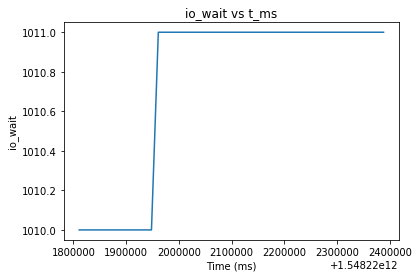

hard_interrupts
('mean=', 4865259.965909091, 'stddev=', 260700.19755118352)


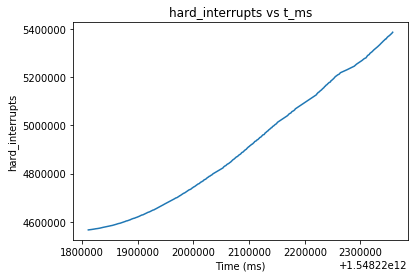

server_requests
('mean=', 30961.15056818182, 'stddev=', 3157.0899400018748)


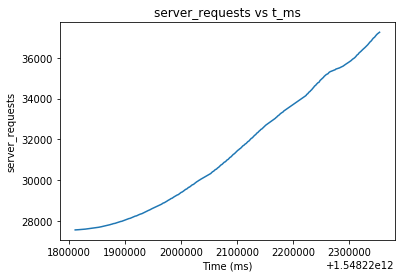

context_switches
('mean=', 4090029.0681818184, 'stddev=', 202504.38370385824)


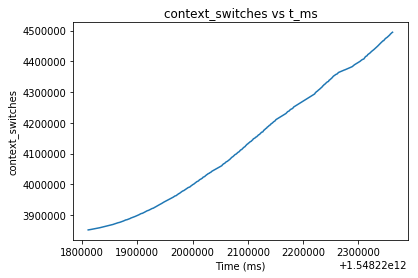

client_requests.successful
('mean=', 30543.392045454544, 'stddev=', 3150.4047223304783)


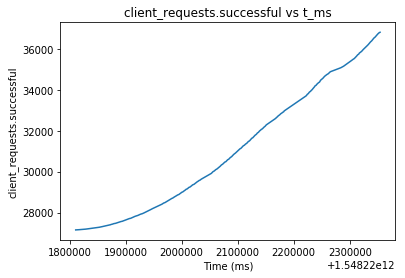

client_requests.failed
('mean=', 442.3693181818182, 'stddev=', 0.7229764793334715)


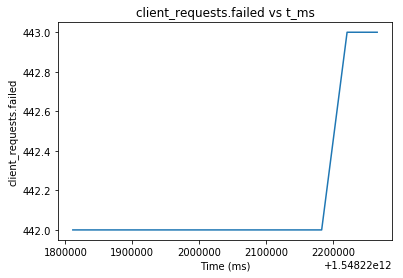

client_requests.sent
('mean=', 31153.096590909092, 'stddev=', 3159.7825671004666)


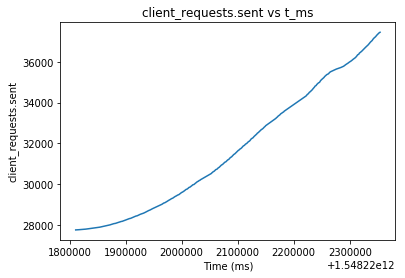

duration
('mean=', 0.1492177965966138, 'stddev=', 0.15211393398433087)


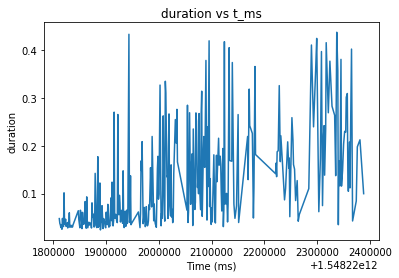

t_ms
('mean=', 1548222054579.5454, 'stddev=', 163828.03287086994)


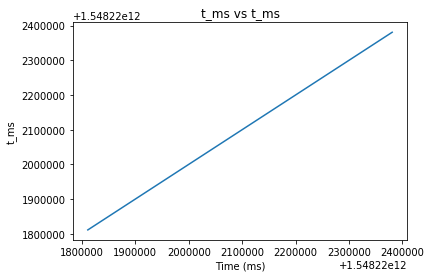

soft_interrupts
('mean=', 4745858.673295454, 'stddev=', 260644.89883181968)


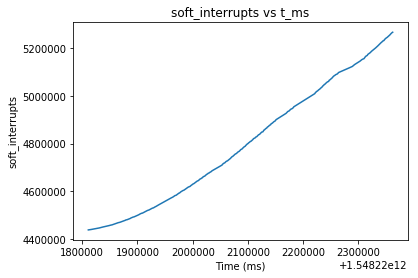

cpu.nice
('mean=', 332.0, 'stddev=', 0.0)


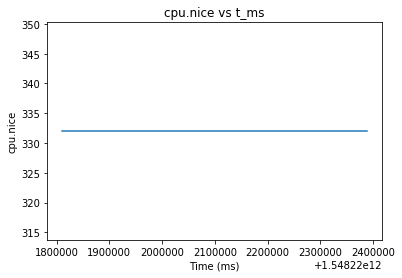

cpu.user
('mean=', 222113.9346590909, 'stddev=', 17565.399578941826)


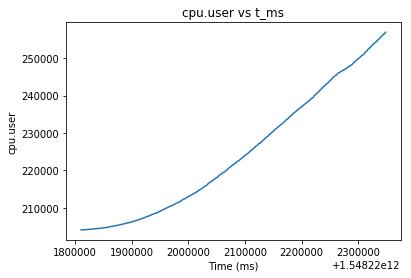

cpu.system
('mean=', 88372.90340909091, 'stddev=', 4192.415126504402)


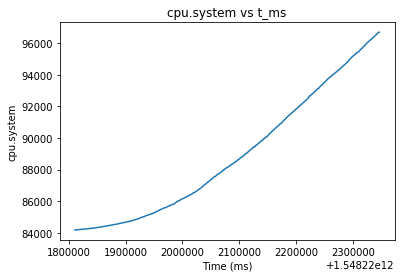

io_wait
('mean=', 1.721763085399449e-05, 'stddev=', 0.00032257221066107433)


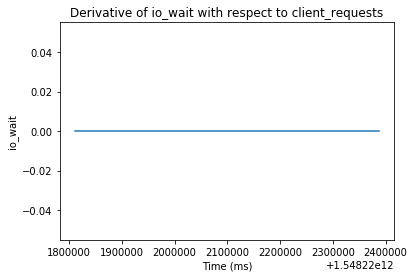

hard_interrupts
('mean=', 93.1727634173761, 'stddev=', 36.21771847267297)


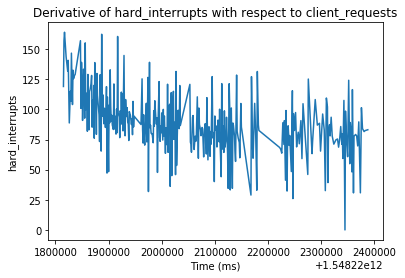

server_requests
('mean=', 1.0107411876635235, 'stddev=', 0.14825088641007925)


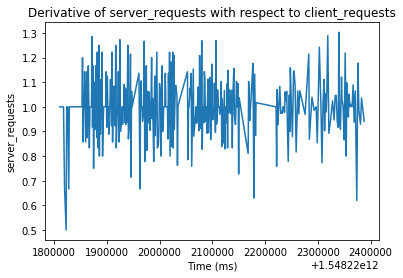

context_switches
('mean=', 76.45062296790265, 'stddev=', 35.808115041886694)


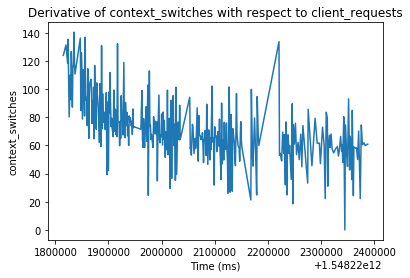

client_requests.successful
('mean=', 1.0, 'stddev=', 0.0)


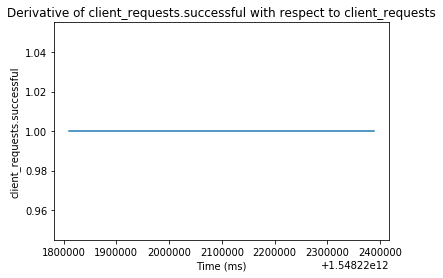

client_requests.failed
('mean=', 3.488072705004732e-05, 'stddev=', 0.0005831510097952508)


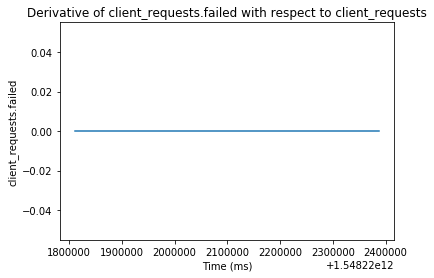

client_requests.sent
('mean=', 1.0100200930045624, 'stddev=', 0.15923716093327606)


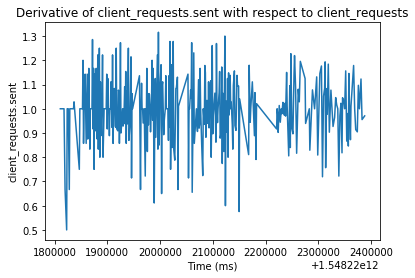

duration
('mean=', -0.00025189312895010715, 'stddev=', 0.008194802562752693)


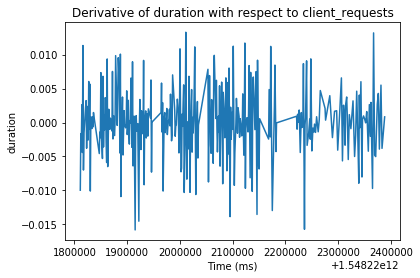

t_ms
('mean=', 95.53613218103469, 'stddev=', 121.0333873534985)


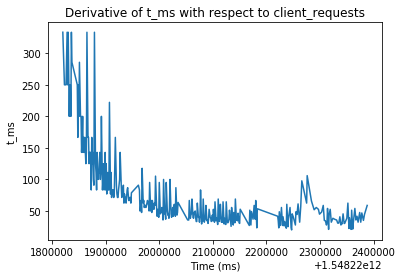

soft_interrupts
('mean=', 98.05606302717933, 'stddev=', 43.53086697836679)


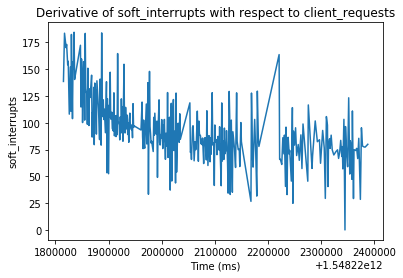

cpu.nice
('mean=', 0.0, 'stddev=', 0.0)


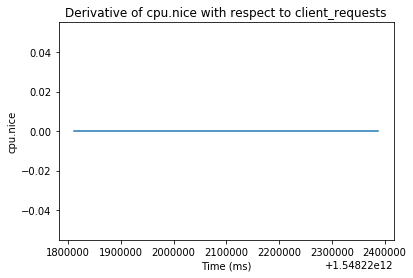

cpu.user
('mean=', 5.1480993441059315, 'stddev=', 1.7067613519033307)


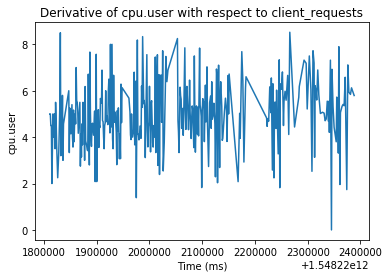

cpu.system
('mean=', 1.1934232859166636, 'stddev=', 0.5027875887855582)


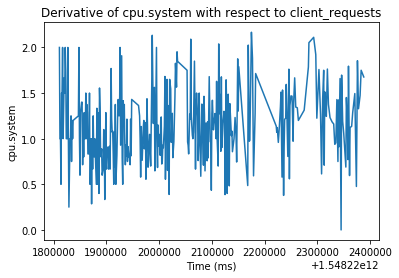

('Caught exception', HTTP 599: Timeout during request)
('Caught exception', HTTP 599: Timeout during request)


In [10]:
%matplotlib inline

import json
import operator
import collections
import numpy

import matplotlib.pyplot as plt

"""
{
  "client_requests": {
      "sent": 0,
      "successful": 0,
      "failed": 0
  },
  "context_switches": 4547728.0,
  "cpu": {
    "nice": 0,
    "system": 0,
    "user": 0
  },
  "hard_interrupts": 2532947.0,
  "io_wait": 522.0,
  "server_requests": 59.0,
  "soft_interrupts": 4159395.0,
  "t_ms": 1548168797278.9885
}
"""

def derivative(stats, i, value_accessor, delta_accessor=None):            
    nxt_val = float(accessor(stats[i+1]))
    cur_val = float(accessor(stats[i]))
    
    delta = 1.
    if delta_accessor:
        nxt_del = float(delta_accessor(stats[i+1]))
        cur_del = float(delta_accessor(stats[i]))
        delta = (nxt_del - cur_del)
    
    return (nxt_val - cur_val) / delta


def accessor_lists(template):
    for k, v in template.items():
        if not isinstance(v, dict):
            yield [k], [operator.itemgetter(k)]
        else:
            for keys, accessor_list in accessor_lists(template[k]):
                yield [k] + keys, [operator.itemgetter(k)] + accessor_list


def access(stat, accessor_list):
    v = stat
    for acc in accessor_list:
        v = acc(v)
    return v


def plot_points(title, x_label, y_label, points):
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    X, Y = points
    plt.plot(X, Y)
    plt.show()


def plot_stats(stats, derivative=False):
    template = stats[0]
    for labels, accessor_list in accessor_lists(template):
        print(".".join(labels))
        X, Y, points = [], [], []
        for i, stat in enumerate(stats):
            if i == len(stats) - 1:
                break
            if not derivative:
                x = stat.get('t_ms')
                y = access(stat, accessor_list)
            else:
                nxt_x = stats[i+1].get('client_requests', {}).get('successful', 0)
                cur_x = stats[i].get('client_requests', {}).get('successful', 0)
                nxt_y = access(stats[i+1], accessor_list)
                cur_y = access(stats[i], accessor_list)
                x = stat.get('t_ms')
                y = (nxt_y - cur_y) / ((nxt_x - cur_x) or 10e-8)
            X.append(x)
            Y.append(y)
        title = ".".join(labels) + " vs t_ms"
        if derivative:
            title = "Derivative of " + ".".join(labels) + " with respect to client_requests"
        plot_points(title, "Time (ms)", ".".join(labels), remove_outliers(X, Y))


def cast_ts_to_bin(ts, bin_size):
    return int(ts / bin_size) * bin_size
        
        
def bin_stats(stats, ms_bin=100):
    binned = collections.defaultdict(dict)
    for stat in stats:
        bin = cast_ts_to_bin(stat.get('t_ms'), ms_bin)
        binned[bin] = add_stats(stat, binned[bin])
        binned[bin]['t_ms'] = bin
    return sorted([b for b in binned.values()], key=lambda o: o.get('t_ms'))


def remove_outliers(X, Y):
    #return X, Y
    stddev = numpy.std(Y)
    mean = numpy.mean(Y)
    three_sigma = 2 * stddev
    removed_outliers_X, removed_outliers_Y = [], []
    print('mean=', mean, 'stddev=', stddev)
    for x, y in zip(X, Y):
        if numpy.abs(y) > (three_sigma + mean):
            continue
        removed_outliers_X.append(x)
        removed_outliers_Y.append(y)
    return removed_outliers_X, removed_outliers_Y
        
        
def add_stats(a, b):
    c = {}
    for k, v in a.items():
        if isinstance(v, dict):
            c[k] = add_stats(a.get(k, {}), b.get(k, {}))
        else:
            c[k] = a.get(k, 0.) + b.get(k, 0.)
    return c

binned = bin_stats(cpu_stats[1:], ms_bin=1000.)
        
plot_stats(binned[1:], derivative=False)
plot_stats(binned[1:], derivative=True)


In [3]:
len(cpu_stats)


23